# 循环神经网络

# 循环神经网络从零开始实现

In [17]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

#num_steps每一次看多长的序列
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
#vocab里面并不是存了整个文本，而是文本里面所有的词汇表
print(len(vocab)) #28
print(list(vocab.token_to_idx.items()))

[('<unk>', 0), (' ', 1), ('e', 2), ('t', 3), ('a', 4), ('i', 5), ('n', 6), ('o', 7), ('s', 8), ('h', 9), ('r', 10), ('d', 11), ('l', 12), ('m', 13), ('u', 14), ('c', 15), ('f', 16), ('w', 17), ('g', 18), ('y', 19), ('p', 20), ('b', 21), ('v', 22), ('k', 23), ('x', 24), ('z', 25), ('j', 26), ('q', 27)]


In [12]:
#给一个向量，指定下标，变成one_hot编码
F.one_hot(torch.tensor([0,2]),len(vocab))



In [11]:
#小批量数据形状是（批量大小，时间步数）
X = torch.arange(10).reshape((2, 5))
#做转置是为了把时间放在前面 (时间，batch,28) 访问每个时间的时候 都可以访问连续的
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## 初始化循环神经网络模型的模型参数

In [18]:
def get_params(vocab_size, num_hiddens, device):
    #输出是预测下一个词，多类分类的问题，应该是vocab里面的任何一个词
    #输入通过one_hot编码之后，就变成一个长为28的向量
    num_inputs = num_outputs = vocab_size

    #均值为0，方差为0.01的函数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    #把输入x映射到隐藏层输入的大小
    W_xh = normal((num_inputs, num_hiddens))
    #上一个时刻的隐藏变量变换到下一个时刻的隐藏变量
    W_hh = normal((num_hiddens, num_hiddens)) ##RNN的唯一区别，去掉就是单隐藏层的MLP
    #每一个隐藏层的偏置
    b_h = torch.zeros(num_hiddens, device=device)
    #隐藏变量到输出
    W_hq = normal((num_hiddens, num_outputs))
    #偏置
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [19]:
#初始化隐藏状态 隐藏变量是一个num_hiddens的变量
#把隐藏状态做成了一个tuple,这里只有一个变量，之后的LSTM有两个
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [21]:
#计算隐藏状态和输出 套用公式

#inputs包含了所有的时间步 state是初始化的隐藏状态 params是可学习的参数
#与MLP不同的是：输入不再是batch_size*样本，多了一个时间维度;需要输入初始的隐藏状态，输出隐藏状态

def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    #inputs是一个3D （时间序列长度，batch_size,vocab_size) 
    #沿着第一个维度取遍历（时间序列长度）
    for X in inputs:
        #下一个时刻的隐藏层状态
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        #mei'yi
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    
    #dim=0拼接起来，列数还是vpcab_size,行数是 时间*batch_size
    #H是输出更新后的隐藏状态
    return torch.cat(outputs, dim=0), (H,)

In [22]:
#创造一个类包装这些函数
class RNNModelScratch:  
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        #forward_fn就是rnn函数
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        #输入的X是  #这个X是batch_size*时间序列
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [23]:
#写个测试 检验一下输出是否满足我们的要求
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)

#X是我们自己定义的2*5
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
#new_state[0]是一个批量大小，更新后的隐藏元的维度
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

## 文本生成，做词的预测

In [29]:
#文本生成 做一个个词预测
#定义预测函数来生成prefix之后的词
#prefix是已知的字符，num_preds是生成多少个词
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1, device=device)
    #拿到prefix[0]在vocab里面对应的下标
    outputs = [vocab[prefix[0]]]
    #最近预测的一个词做成一个tensor，作为下一时刻的输入
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    #这个并不关心输出，只是把这个状态保存下来
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        #把y里面最大的那个拿出来 得到了预测的下标
        outputs.append(int(y.argmax(dim=1).reshape(1)))
        #把index转成token
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller qelspawtky'

## 梯度剪裁

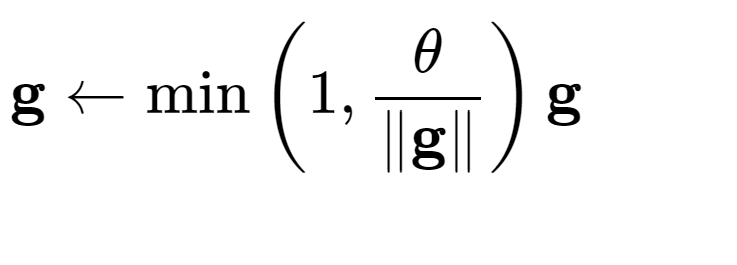

In [30]:
#需要做35次迭代，35个矩阵的乘法，容易有梯度爆炸
def grad_clipping(net, theta):  
    """裁剪梯度。"""
    #如果用的是API
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    #不然的话，从零开始实现的
    #把所有的层可以参与训练的参数都拿出来了
    else:
        params = net.params
    #所有层的梯度都拿出来求和，最后求长度
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 定义一个函数来训练只有一个迭代周期的模型

In [31]:
'''
#3点不一样
#state
#梯度裁剪
#评价指标：困惑度
'''

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    #存各种loss信息
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        #use_random_iter上一个batch和下一个batch之间没有时序信息，需要重新初始化state
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                #detach()是不改变里面的内容，做反向传播的时候，前面那些计算图不要，只关注当前的
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        #y做了转置，是把时间序列放到了前面
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        #把Y拉成一个（时间序列*batch_size,vocab_size)这样对于loss来说有（时间序列*batch_size）这么多个样本，转化成了多分类问题
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
        #metric[0]里面是所有的loss metric[1]是样本数量
        #返回的第一个值是困惑度
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [32]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 90347.8 标记/秒 cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


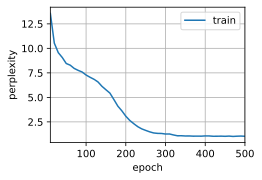

In [33]:
#训练神经网络模型
num_epochs, lr = 500, 1
#给一个词预测下一个词 词给出来的还挺正常的 句子是不靠谱的
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.3, 90878.4 标记/秒 cuda:0
time traveller but now you begin to seethe object of my investig
traveller but now you begin to seethe object of my investig


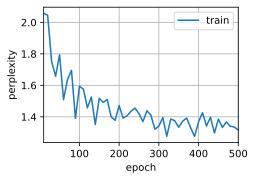

In [34]:
#最后，检查一下使用随机抽样方法的结果
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

# 循环神经网络的简洁实现

In [35]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 定义模型

In [36]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

## 使用张量初始化隐藏状态

In [37]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

## 通过隐藏层状态和一个输入，可以使用更新后的隐藏层状态计算输出

In [38]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
#Y （时间，批量，隐藏层大小）
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

## 为一个完整的循环神经网络模型定义一个RNNModule类

In [39]:
class RNNModel(nn.Module):
    """循环神经网络模型。"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        #自定义的RNN包括了输出层，调用的nn.RNN没有输出层，只有隐藏层
        if not self.rnn.bidirectional:
            self.num_directions = 1
            #构造自己的输出层
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        #Y原本是（时间序列，批量大小，隐藏大小）3D
        #现在变成2D （时间序列*批量大小，隐藏大小）
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

In [40]:
#基于一个具有随机权重的模型进行预测
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerxx<unk>xmshhxx'

perplexity 1.3, 279824.3 tokens/sec on cuda:0
time traveller pall the ormeth hryout for ow wermatsma lone an t
travellerhes la g ttrea lozimby bace the limilat for whil b


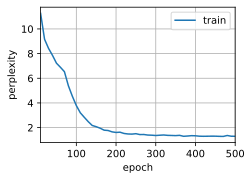

In [41]:
#训练 这个更快 因为从零开始实现是一些小矩阵乘法，API是做成一个大矩阵然后做乘法
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

# 答疑

- num_steps是时间维度，小批量里面的一个样本的一个句子的长度，类似于隐藏层层数
- torchserve
- H更新是每个时间状态会更新一次
- 时间是句子的长度，batch_size一次训练训练多少个样本
- 梯度是一个batch更新一次
- 模型不能被用户的数据带偏，模型不能随着用户的输入改变，也就是不能用用户的数据去训练模型
- 用RNN做气温预测
- 梯度每次batch之后都会被记住，detach会记住前面那些东西，计算误差反传的时候那些东西会被记住，detach就是说之前那些东西都不要了，只关注当前的东西。
- RNN看不了很长的序列，最多是100以内。
- 预测用的是字符而不是单词，字符只有28个，单词的话会有上千个单词，计算量太大
- 有35个隐藏层，每个隐藏层变量有512个单元，如果要记住很长的序列，变量长度不够，当然也可以做长，但是这样就容易过拟合，RNN是最简单的做时序的模型，类似MLP。
- 高频字符做低采样
- 车作为未来的超级计算机，车内的娱乐和车外的无人驾驶